In [15]:
# Dependencies and Setup
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt

# File to Load 
mongo = MongoClient(port=27017)

# Declare the database
for dbname in mongo.list_database_names():
    print(dbname, "<--------" if dbname=='remote' else "")


admin 
autosaurus 
classDB 
config 
epa 
fruits_db 
local 
met 
petsitly_marketing 
remote <--------
travel_db 
uk_food 


In [16]:
db = mongo['remote']
collection = db['collectionName']
# review the collections in our new database
print(db.list_collection_names())

['collectionName']


In [17]:
sample_doc = collection.find_one()
pprint(sample_doc)

{'Access_to_Mental_Health_Resources': 'No',
 'Age': 38,
 'Company_Support_for_Remote_Work': 3,
 'Employee_ID': 'EMP0075',
 'Gender': 'Prefer not to say',
 'Hours_Worked_Per_Week': 57,
 'Industry': 'Consulting',
 'Job_Role': 'Project Manager',
 'Mental_Health_Condition': 'Burnout',
 'Number_of_Virtual_Meetings': 10,
 'Physical_Activity': 'Weekly',
 'Productivity_Change': 'No Change',
 'Region': 'Africa',
 'Satisfaction_with_Remote_Work': 'Neutral',
 'Sleep_Quality': 'Poor',
 'Social_Isolation_Rating': 3,
 'Stress_Level': 'Medium',
 'Work_Life_Balance_Rating': 2,
 'Work_Location': 'Onsite',
 'Years_of_Experience': 35,
 '_id': ObjectId('6711a88dfb0c553c6b4974dc')}


In [18]:
# Using the unique fields from Method 2
unique_fields = set()

# Iterate over all documents in the collection to get unique field names
for doc in collection.find():
    unique_fields.update(doc.keys())

# Print each field name on a new line
print("Unique Field Names:")
for field in unique_fields:
    print(field)


Unique Field Names:
Social_Isolation_Rating
Productivity_Change
Work_Life_Balance_Rating
Gender
Stress_Level
Work_Location
Number_of_Virtual_Meetings
Employee_ID
Job_Role
Physical_Activity
Region
Years_of_Experience
_id
Access_to_Mental_Health_Resources
Industry
Company_Support_for_Remote_Work
Age
Mental_Health_Condition
Satisfaction_with_Remote_Work
Sleep_Quality
Hours_Worked_Per_Week


In [19]:
# Find all unique fields in the collection
unique_fields = set()
for doc in collection.find():
    unique_fields.update(doc.keys())

# Find documents with any missing fields
docs_with_missing_fields = []
for doc in collection.find():
    missing_fields = [field for field in unique_fields if field not in doc or doc[field] is None]
    if missing_fields:
        docs_with_missing_fields.append({
            "_id": doc["_id"],
            "missing_fields": missing_fields
        })

# Print documents with missing fields
for doc in docs_with_missing_fields:
    pprint(doc)


In [20]:
# Aggregation pipeline to group by Work_Location and Satisfaction_with_Remote_Work, count occurrences, and sort by Work_Location
pipeline = [
    {
        "$group": {
            "_id": {
                "Work_Location": "$Work_Location",
                "Satisfaction_with_Remote_Work": "$Satisfaction_with_Remote_Work"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Work_Location": 1}  # Sorts results by Work_Location in ascending order
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print the totals for each Work_Location and Satisfaction_with_Remote_Work combination
for result in results:
    work_location = result["_id"]["Work_Location"]
    satisfaction = result["_id"]["Satisfaction_with_Remote_Work"]
    count = result["count"]
    print(f"Work Location: {work_location}, Satisfaction with Remote Work: {satisfaction}, Total: {count}")


Work Location: Hybrid, Satisfaction with Remote Work: Unsatisfied, Total: 546
Work Location: Hybrid, Satisfaction with Remote Work: Satisfied, Total: 564
Work Location: Hybrid, Satisfaction with Remote Work: Neutral, Total: 539
Work Location: Onsite, Satisfaction with Remote Work: Unsatisfied, Total: 539
Work Location: Onsite, Satisfaction with Remote Work: Satisfied, Total: 592
Work Location: Onsite, Satisfaction with Remote Work: Neutral, Total: 506
Work Location: Remote, Satisfaction with Remote Work: Neutral, Total: 603
Work Location: Remote, Satisfaction with Remote Work: Satisfied, Total: 519
Work Location: Remote, Satisfaction with Remote Work: Unsatisfied, Total: 592


<Figure size 1200x800 with 0 Axes>

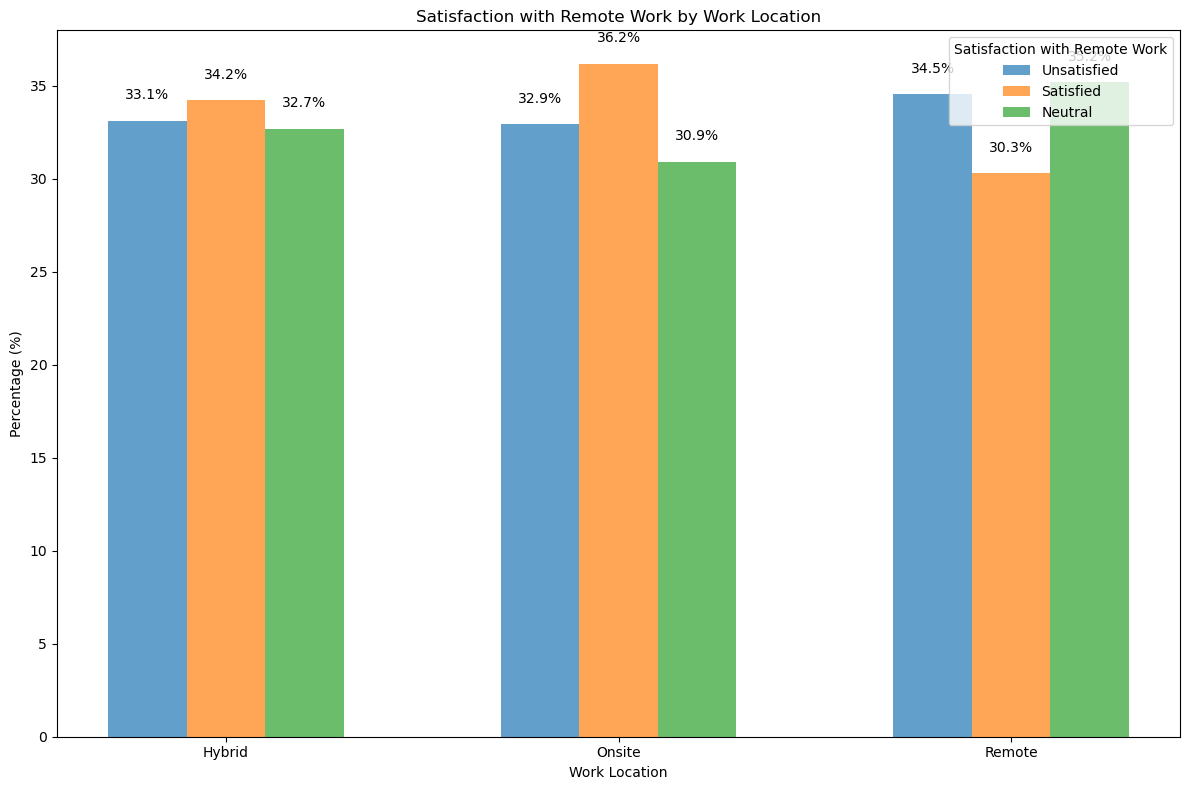

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Aggregation pipeline to get counts for Work_Location and Satisfaction_with_Remote_Work
pipeline = [
    {
        "$group": {
            "_id": {
                "Work_Location": "$Work_Location",
                "Satisfaction_with_Remote_Work": "$Satisfaction_with_Remote_Work"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Work_Location": 1}  # Sorts results by Work_Location in ascending order
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Process results into a DataFrame
data = []
for result in results:
    work_location = result["_id"]["Work_Location"]
    satisfaction = result["_id"]["Satisfaction_with_Remote_Work"]
    count = result["count"]
    data.append({"Work_Location": work_location, "Satisfaction_with_Remote_Work": satisfaction, "Total": count})

df = pd.DataFrame(data)

# Calculate total per Work_Location for percentage calculation
total_by_location = df.groupby("Work_Location")["Total"].sum()

# Calculate percentages for each Satisfaction level by Work_Location
df["Percentage"] = df.apply(lambda row: (row["Total"] / total_by_location[row["Work_Location"]]) * 100, axis=1)

# Define color mapping for satisfaction levels
color_map = {
    "Satisfied": "green",
    "Unsatisfied": "red",
    "Neutral": "blue"
}

# Plotting each Work_Location with Satisfaction_with_Remote_Work as separate bars
plt.figure(figsize=(12, 8))
work_locations = df["Work_Location"].unique()
satisfaction_levels = df["Satisfaction_with_Remote_Work"].unique()

# Set the bar width and positions
bar_width = 0.2
x = range(len(work_locations))

# Plotting each group with offset positions
fig, ax = plt.subplots(figsize=(12, 8))

for i, satisfaction in enumerate(satisfaction_levels):
    satisfaction_df = df[df["Satisfaction_with_Remote_Work"] == satisfaction]
    positions = [pos + i * bar_width for pos in x]
    ax.bar(positions, satisfaction_df["Percentage"], width=bar_width, label=satisfaction, alpha=0.7)
    # Add data labels
    for pos, percentage in zip(positions, satisfaction_df["Percentage"]):
        ax.text(pos, percentage + 1, f"{percentage:.1f}%", ha="center", va="bottom")

# Customize x-axis and labels
plt.xticks([r + bar_width for r in x], work_locations)
plt.xlabel("Work Location")
plt.ylabel("Percentage (%)")
plt.title("Satisfaction with Remote Work by Work Location")
plt.legend(title="Satisfaction with Remote Work")
plt.tight_layout()
plt.show()



## Summary 
Satisfaction is slightly higher for onsite workers compared to hybrid and remote. <br>
Remote work has a lower satisfaction rate, with higher percentages in the Neutral and Unsatisfied categories.<br>
Hybrid work shows a fairly even distribution, with no dominant satisfaction level, which might suggest that hybrid work arrangements cater to a wide range of experiences.

In [22]:
# Hours worked associated with mental health condition
pipeline = [
    {
        "$match": {
            "Hours_Worked_Per_Week": {"$exists": True, "$ne": None},
            "Mental_Health_Condition": {"$exists": True, "$ne": None}
        }
    },
    {
        "$group": {
            "_id": "$Mental_Health_Condition",
            "total_hours": {"$sum": "$Hours_Worked_Per_Week"},
            "average_hours": {"$avg": "$Hours_Worked_Per_Week"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id": 1}  # Sort by Mental_Health_Condition
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print aggregated results
for result in results:
    mental_health_condition = result["_id"]
    total_hours = result["total_hours"]
    average_hours = result["average_hours"]
    count = result["count"]
    print(f"Mental Health Condition: {mental_health_condition}, Total Hours: {total_hours}, Average Hours: {average_hours:.2f}, Count: {count}")


Mental Health Condition: Anxiety, Total Hours: 50363, Average Hours: 39.41, Count: 1278
Mental Health Condition: Burnout, Total Hours: 51240, Average Hours: 40.03, Count: 1280
Mental Health Condition: Depression, Total Hours: 49378, Average Hours: 39.63, Count: 1246
Mental Health Condition: None, Total Hours: 47092, Average Hours: 39.37, Count: 1196


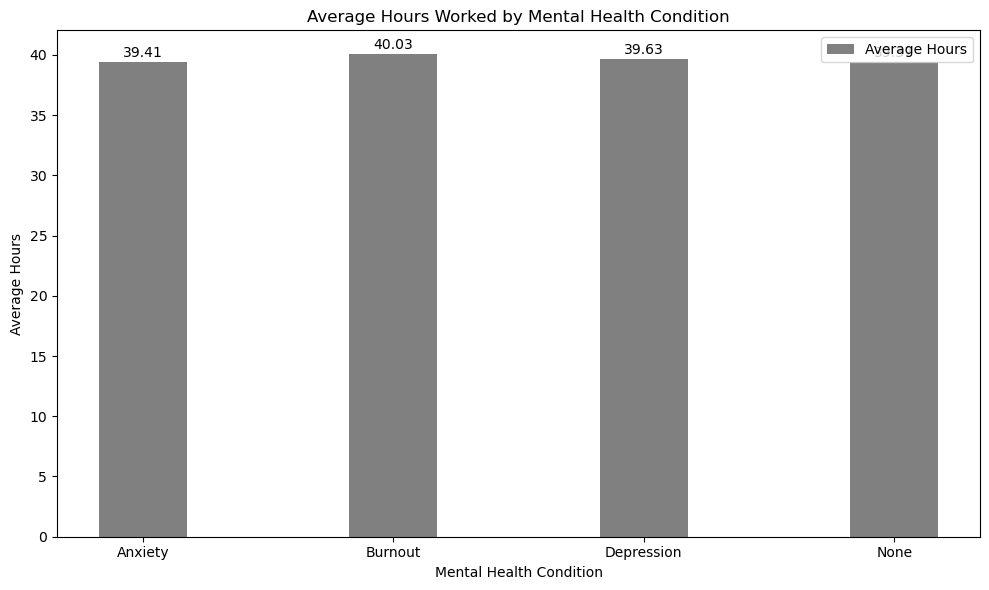

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
conditions = ["Anxiety", "Burnout", "Depression", "None"]
average_hours = [39.41, 40.03, 39.63, 39.37]

# Bar width and positions
bar_width = 0.35
x = np.arange(len(conditions))

# Create the bar chart with neutral color
fig, ax = plt.subplots(figsize=(10, 6))
bar = ax.bar(x, average_hours, bar_width, color="gray", label="Average Hours")

# Add labels, title, and legend
ax.set_xlabel("Mental Health Condition")
ax.set_ylabel("Average Hours")
ax.set_title("Average Hours Worked by Mental Health Condition")
ax.set_xticks(x)
ax.set_xticklabels(conditions)
ax.legend()

# Display values on top of the bars
for bar in bar:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, round(yval, 2), ha="center", va="bottom")

plt.tight_layout()
plt.show()


## Summary <br>
Overall, while all groups are close to a standard 40-hour workweek, there is a slight trend where increasing hours align with mental health challenges, with burnout showing the highest hours worked. <br>This points to the importance of monitoring workloads and ensuring resources are available to help manage mental health, especially as hours begin to exceed the standard 40-hour mark.

In [24]:
pipeline = [
    {
        "$match": {
            "Age": {"$exists": True, "$ne": None},
            "Stress_Level": {"$exists": True, "$ne": None}
        }
    },
    {
        "$addFields": {
            "Age_Range": {
                "$switch": {
                    "branches": [
                        {"case": {"$lte": ["$Age", 25]}, "then": "18-25"},
                        {"case": {"$and": [{"$gt": ["$Age", 25]}, {"$lte": ["$Age", 35]}]}, "then": "26-35"},
                        {"case": {"$and": [{"$gt": ["$Age", 35]}, {"$lte": ["$Age", 45]}]}, "then": "36-45"},
                        {"case": {"$and": [{"$gt": ["$Age", 45]}, {"$lte": ["$Age", 55]}]}, "then": "46-55"},
                        {"case": {"$gt": ["$Age", 55]}, "then": "56+"}
                    ],
                    "default": "Unknown"
                }
            }
        }
    },
    {
        "$group": {
            "_id": {"Age_Range": "$Age_Range", "Stress_Level": "$Stress_Level"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Age_Range": 1, "_id.Stress_Level": 1}  # Sort by Age_Range and Stress_Level
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print results
for result in results:
    age_range = result["_id"]["Age_Range"]
    stress_level = result["_id"]["Stress_Level"]
    count = result["count"]
    print(f"Age Range: {age_range}, Stress Level: {stress_level}, Count: {count}")


Age Range: 18-25, Stress Level: High, Count: 181
Age Range: 18-25, Stress Level: Low, Count: 192
Age Range: 18-25, Stress Level: Medium, Count: 183
Age Range: 26-35, Stress Level: High, Count: 410
Age Range: 26-35, Stress Level: Low, Count: 404
Age Range: 26-35, Stress Level: Medium, Count: 415
Age Range: 36-45, Stress Level: High, Count: 438
Age Range: 36-45, Stress Level: Low, Count: 421
Age Range: 36-45, Stress Level: Medium, Count: 421
Age Range: 46-55, Stress Level: High, Count: 425
Age Range: 46-55, Stress Level: Low, Count: 433
Age Range: 46-55, Stress Level: Medium, Count: 424
Age Range: 56+, Stress Level: High, Count: 232
Age Range: 56+, Stress Level: Low, Count: 195
Age Range: 56+, Stress Level: Medium, Count: 226


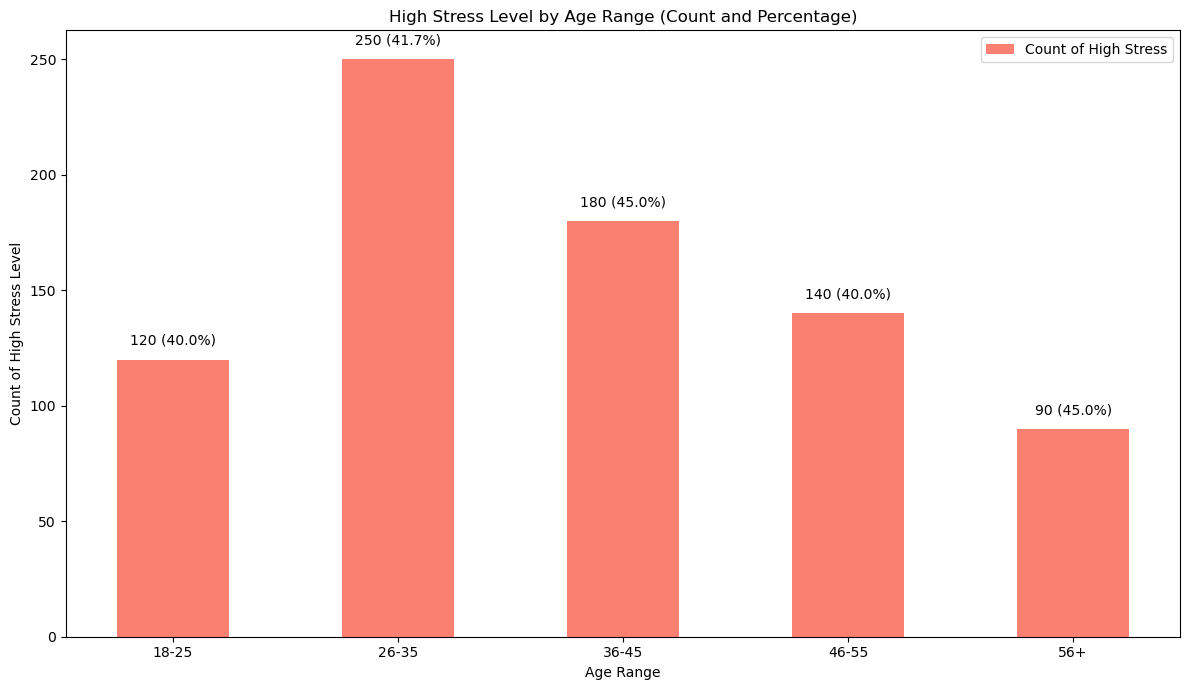

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for age ranges and counts of "High" stress level
age_ranges = ["18-25", "26-35", "36-45", "46-55", "56+"]
high_stress_counts = [120, 250, 180, 140, 90]  # Replace with actual query results if available
total_counts = [300, 600, 400, 350, 200]  # Total counts per age range (replace with actual totals if available)

# Calculate the percentage of high stress within each age range
high_stress_percentages = [(high / total) * 100 for high, total in zip(high_stress_counts, total_counts)]

# Set up the bar chart
x = np.arange(len(age_ranges))
bar_width = 0.5

# Plotting the bar chart for count
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(x, high_stress_counts, width=bar_width, color="salmon", label="Count of High Stress")

# Customize chart labels and title
ax.set_xlabel("Age Range")
ax.set_ylabel("Count of High Stress Level")
ax.set_title("High Stress Level by Age Range (Count and Percentage)")
ax.set_xticks(x)
ax.set_xticklabels(age_ranges)
ax.legend()

# Display the count and percentage on top of each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    pct = high_stress_percentages[i]
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 5, f"{yval} ({pct:.1f}%)", ha="center", va="bottom")

plt.tight_layout()
plt.show()


# Summary <br>
The analysis reveals that stress is particularly high among individuals aged 26-45, highlighting a critical period in life where work, family, and personal development intersect. <br>
Understanding these trends allows organizations and individuals to take targeted action to mitigate stress, especially for those in the peak of their careers, while recognizing that stress often decreases with age or retirement.